63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test MAE (scaled): 0.0077 | Original MAE: 0.50
R² Score: 0.9947 (closer to 1 is better)


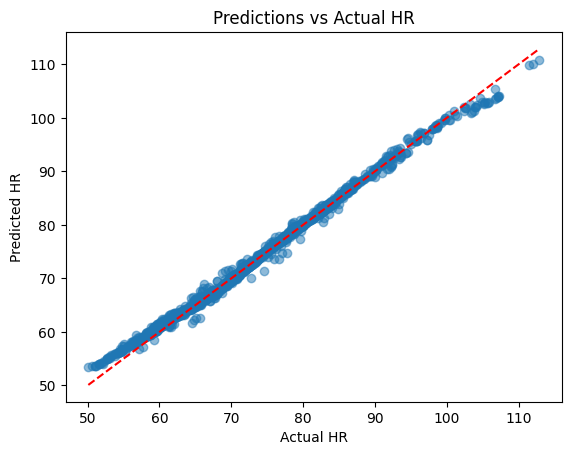

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted HR for sample: 71.04


d:\Programming\Python\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


In [2]:
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd  # FIXED: Add import pd
from sklearn.model_selection import train_test_split
import os

# FIXED: Absolute paths
PROJECT_ROOT = r"D:\Work\Stress_Level_Prediction\data"
TRAIN_TIME = os.path.join(PROJECT_ROOT, 'Train Data', 'Train Data Zip', 'time_domain_features_train.csv')
TRAIN_FREQ = os.path.join(PROJECT_ROOT, 'Train Data', 'Train Data Zip', 'frequency_domain_features_train.csv')

# Load merged data (re-run merge for evaluation)
df_time = pd.read_csv(TRAIN_TIME)
df_freq = pd.read_csv(TRAIN_FREQ)
df = pd.merge(df_time, df_freq, on='uuid', how='inner')

# Sample for speed
df = df.sample(n=10000, random_state=42).reset_index(drop=True)

features = ['MEAN_RR', 'SDRR', 'LF', 'HF']
X = df[features]
y = df['HR'].values.reshape(-1, 1)

# Load scalers
scaler_X = joblib.load('../models/scaler_X.pkl')
scaler_y = joblib.load('../models/scaler_y.pkl')

X_scaled = scaler_X.transform(X)
y_scaled = scaler_y.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Load model
model = tf.keras.models.load_model('../models/stress_nn_model.h5')

# Evaluate
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

y_pred_scaled = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test_orig = scaler_y.inverse_transform(y_test)

mae = mean_absolute_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f"Test MAE (scaled): {test_mae:.4f} | Original MAE: {mae:.2f}")
print(f"R² Score: {r2:.4f} (closer to 1 is better)")

# Plot
plt.scatter(y_test_orig, y_pred, alpha=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], [y_test_orig.min(), y_test_orig.max()], 'r--')
plt.xlabel('Actual HR')
plt.ylabel('Predicted HR')
plt.title('Predictions vs Actual HR')
plt.show()

# Example prediction
new_data = np.array([[885, 140, 1009, 100]])  # Sample from head
new_data_scaled = scaler_X.transform(new_data)
pred_scaled = model.predict(new_data_scaled)
pred = scaler_y.inverse_transform(pred_scaled)[0][0]
print(f"Predicted HR for sample: {pred:.2f}")